# ArgText results - Threshold exploration

Mike Pesavento  
started: 2020.07.27  


What happens when we change the threshold on the ArgText output?  
How does that change the results and accuracy of how we measure the model?   
Is having a lower threshold worth having more false positives on the arguments, at benefit of having more data?

In this exploration, I'm going to look at what happens when we change the "soft arguments" that I had labeled as `2` into an "is argument, labeled as a `1`. I will also look at different sentences that are added to the "is argument" set as we decrease the threshold, seeing how the quality of arguments may or may not change.

In [1]:
# reload local package definitions for each cell
%load_ext autoreload
%autoreload 2

In [18]:
import os
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from arg_mine import DATA_DIR, FIGURES_DIR
from arg_mine.data import loaders, labelers
from arg_mine.api import classify, auth, session, errors
from arg_mine.visualization.plot_utils import make_confusion_matrix, make_roc_curve, make_precision_recall_curve
from arg_mine import utils
from arg_mine.metrics import summary_stats


SEED = 12345

sns.set_style("whitegrid")

## Load the reviewed data

In [6]:
# load all sentences to get an estimate of argument percentages
start_time = time.time()
data_processed_project = "gdelt-climate-change-docs"
base_path = os.path.join(DATA_DIR, "processed", data_processed_project)
docs_df = loaders.load_processed_csv("gdelt_2020_docs_docs0-999.csv", data_processed_project)

print("data load took {:0.1f} s".format(time.time() - start_time))

sentences_full_df = loaders.load_processed_csv("gdelt_2020_sentences_docs0-999.csv", data_processed_project, drop_nan_cols='sentence_original')

INFO:2020-07-27 22:26:53,351:arg_mine.data.loaders: reading data from: /opt/workspace/data/processed/gdelt-climate-change-docs/gdelt_2020_docs_docs0-999.csv
INFO:2020-07-27 22:26:53,371:arg_mine.data.loaders: reading data from: /opt/workspace/data/processed/gdelt-climate-change-docs/gdelt_2020_sentences_docs0-999.csv


data load took 0.0 s


In [7]:
# set the class percentages to define the natural sample rate
arg_label_counts = sentences_full_df.argument_label.value_counts()
print(arg_label_counts)
print("\nTotal # of sentences: {}".format( sentences_full_df.shape[0]))
class_pct = arg_label_counts / sentences_full_df.shape[0]
print(class_pct)


no argument    24701
argument        6750
Name: argument_label, dtype: int64

Total # of sentences: 31451
no argument    0.78538
argument       0.21462
Name: argument_label, dtype: float64


In [13]:
# load the reviewed data
review_output_filename = "argtext_sentences_manual_review_1k_reviewed600.csv"
review_output_filename = os.path.join(DATA_DIR, "interim", review_output_filename)

reviewed_sent_df = pd.read_csv(review_output_filename)
reviewed_sent_df.dropna(inplace=True)


# create binary labels from manual labeling
# One set will have the "fuzzy" 2 label as "arg", the other will have it as "not arg"
# Compare the scores

# convert has arg to binary label
reviewed_sent_df["label"] = (reviewed_sent_df.has_argument >=1).astype(int)
reviewed_sent_df["label_nofuzz"] = (reviewed_sent_df.has_argument == 1).astype(int)

In [17]:
# sample based on presumed ground truth labels, NOT the prediction

negative_samples = reviewed_sent_df.loc[reviewed_sent_df["label"] == 0]
n_negative = negative_samples.shape[0]
# TODO: simplify this math? There should be an easier formula than (nneg/pct_neg - nneg). nneg*(1/pct_neg - 1)?
n_positive = np.round(n_negative/class_pct['no argument'] - n_negative).astype(int)
total_samples = np.round(n_negative / class_pct['no argument']).astype(int)
positive_samples = reviewed_sent_df.loc[reviewed_sent_df["label"] == 1].sample(n=n_positive)
reviewed_natural_df = pd.concat([negative_samples, positive_samples]).sample(frac=1).reset_index(drop=True)

y_model = reviewed_natural_df.is_arg.astype(int)
y_model_conf = reviewed_natural_df.argument_confidence
y_label = reviewed_natural_df.label.astype(int)
y_label_nofuzz = reviewed_natural_df.label_nofuzz.astype(int)

stats_natural_fuzz = summary_stats(y_label, y_model, y_model_conf, name="natural classes, 2->1")
stats_natural_fuzz.at["natural classes, 2->1", "threshold"] = 0.5

stats_natural_nofuzz = summary_stats(y_label_nofuzz, y_model, y_model_conf, name="natural classes, 2->0")
stats_natural_nofuzz.at["natural classes, 2->0", "threshold"] = 0.5


stats_natural_df = pd.concat([stats_natural_fuzz, stats_natural_nofuzz])
stats_natural_df

,accuracy,precision,recall,f1_score,roc_auc,threshold
"natural classes, 2->1",0.872483,0.675676,0.781250,0.724638,0.917869,0.5
"natural classes, 2->0",0.869128,0.608108,0.818182,0.697674,0.908642,0.5


Based on this quick evaluation, we should explore coarse changes in threshold between including the fuzz as an argument vs not.  

Having all fuzzy arguments included (2->1) increases the precision significantly, with a minor decrease in recall. This translates to the model selecting fewer false positives (higher precision) but selects fewer true positives (lower recall).

## Examine thresholds on fuzzy vs not fuzzy

Let's start by looking at 3 thresholds to see the effects of including the fuzzy arguments (`2` on the label) vs not.

`has fuzz` means that we include all 2s as part of the positive labels  
`no fuzz` means that all 2s are part of the negative labels. This matches the output from the original accuracy validation study.



In [32]:
# add different thresholds for the natural distribution

thresholds = [0.1, 0.25, 0.5, 0.75, 0.9]
thresh_stats = []
y_thresh_out = {}
label_type = ["has fuzz", "no fuzz"]
for fuzz_state, thresh in itertools.product(label_type, thresholds):
    y_thresh_out[thresh] = (y_model_conf > thresh).astype(int)
    name = "{}, t={}".format(fuzz_state, thresh)
    label = y_label if fuzz_state == "has fuzz" else y_label_nofuzz
    tmp = summary_stats(label, y_thresh_out[thresh], y_model_conf, name=name)
    tmp.at[name, "threshold"] = thresh
    tmp.at[name, "fuzz_state"] = fuzz_state
    thresh_stats.append(tmp)
    
    
    
thresh_stats_df = pd.concat(thresh_stats, axis=0)
thresh_stats_df

,accuracy,precision,recall,f1_score,roc_auc,threshold,fuzz_state
"has fuzz, t=0.1",0.848993,0.606742,0.843750,0.705882,0.917869,0.10,has fuzz
"has fuzz, t=0.25",0.862416,0.638554,0.828125,0.721088,0.917869,0.25,has fuzz
"has fuzz, t=0.5",0.872483,0.675676,0.781250,0.724638,0.917869,0.50,has fuzz
"has fuzz, t=0.75",0.885906,0.767857,0.671875,0.716667,0.917869,0.75,has fuzz
"has fuzz, t=0.9",0.875839,0.800000,0.562500,0.660550,0.917869,0.90,has fuzz
"no fuzz, t=0.1",0.832215,0.528090,0.854545,0.652778,0.908642,0.10,no fuzz
"no fuzz, t=0.25",0.845638,0.554217,0.836364,0.666667,0.908642,0.25,no fuzz
"no fuzz, t=0.5",0.869128,0.608108,0.818182,0.697674,0.908642,0.50,no fuzz
"no fuzz, t=0.75",0.882550,0.678571,0.690909,0.684685,0.908642,0.75,no fuzz
"no fuzz, t=0.9",0.879195,0.711111,0.581818,0.640000,0.908642,0.90,no fuzz


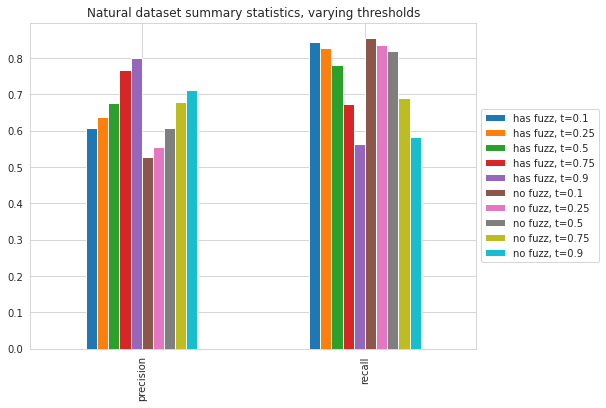

In [33]:
# higher is better for all of these metrics
# thresh_stats_df.drop(["threshold", "fuzz_state"], axis=1).T.plot.bar(figsize=(8,6))
thresh_stats_df[['precision', 'recall']].T.plot.bar(figsize=(8,6))
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
_ = plt.title("Natural dataset summary statistics, varying thresholds")

plt.savefig(os.path.join(FIGURES_DIR, "argtext_validation_382sentence_natural_summary_stats_fuzz.png"), bbox_inches='tight')

The results suggest that having all of the "fuzzy" arguments classified as arguments yields better precision without much change in recall. This is good, cause the model wants to classify all arguments as arguments, independent of the requested topic.

In [11]:
reviewed_sent_df.has_argument

0      0.0
1      1.0
2      0.0
3      2.0
4      2.0
      ... 
597    0.0
598    1.0
599    1.0
600    0.0
601    1.0
Name: has_argument, Length: 602, dtype: float64